# Assignment 2

Use this notebook to write your code for assignment 2

# Dependencies

In [1]:
import math
import string
import time
import unidecode
import random
import re

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

%matplotlib inline

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [2]:
def sonnets(data):
    p = "\d{1,3}"
    return re.split(p, data, flags=re.DOTALL)[1:]

In [3]:
with open("data/shakespeare.txt", "r") as infile:
    data = infile.read()
    
sonnet_data = sonnets(data)

In [4]:
chars = list(set('abcdefghijklmnopqrstuvwxyz'))

data = [i for i in ''.join(sonnet_data).lower() if i in chars]
data_size, vocab_size = len(data), len(chars)
print('There are %d total characters and %d unique characters in your data.' % (data_size, vocab_size))

There are 72955 total characters and 26 unique characters in your data.


In [5]:
char_to_ix = { ch:i for i,ch in enumerate(sorted(chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(chars)) }
print(ix_to_char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z'}


# from tutorial...

In [6]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 98029


In [7]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

h wealth brings,
  That then I scorn to change my state with kings.


                   30
When to the sessions of sweet silent thought,
I summon up remembrance of things past,
I sigh the lack of many


In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Build the Model

Implement a character-based LSTM model 

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [11]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

The main training routine

In [12]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        label = target[c]
        label = label.unsqueeze(0)
        loss += criterion(output, label)

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [14]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 12s (100 5%) 2.1755]
Whe proufonft I serresturithes outt fas iesed,
 of wonde the of bou gaerof m(me force stain do  end.

 

 24s (200 10%) 2.0499]
Wh ware more fatlou dey,
Lor witould my part in the buloth my shat of olcace in poul storenest whe whe 

 37s (300 15%) 1.8557]
Wher thie in mave is in fate ther staise doess ister self allen thight,
As way
Reet cond,
What I thou  

 49s (400 20%) 1.6149]
Wherer tee,
Agrendfore wor eyes in shat,
Whis shour thiy the maing fire self sildich the thou grove th 

 1s (500 25%) 1.6990]
When of then ontilded and seat deprom' blowen reast:
  But compits,
And brcervilden soul and live thei 

 13s (600 30%) 1.6876]
Whee non ornace in the recick,
The all kone day, fill,
And shew one love, ad,
Swerow hast,
And will th 

 26s (700 35%) 1.8639]
Wht truth in intior still did spich prowe rech minded thee caint your bease,
For for your poor it youn 

 37s (800 40%) 1.3926]
What delowed gith thou kladge my love thee rething they shought arace firly mexurs)

# Plotting the Training Losses

Plotting the historical loss during training:

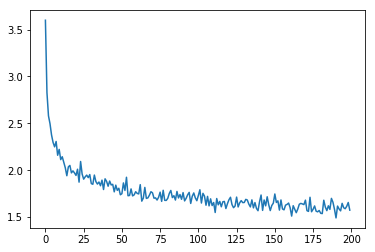

In [17]:
plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.

In [16]:
###